# Bond percolation

In [1]:
%matplotlib inline
from collections.abc import Callable
import copy
import datetime
import joblib
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
import nptyping
import os
import pandas as pd
import seaborn as sns
import warnings

import simulator
import utils

sns.set(font_scale=1.5)

In [2]:
NUM_SAMPLES = 25
SIDE_LENGTH = 50

In [3]:
def initialize(sideLength: int) -> tuple[nx.Graph, Callable[[simulator.BondPercolation], tuple[float, float]]]:
    graph: nx.Graph = nx.grid_2d_graph(sideLength, sideLength)
    mapping: dict[tuple[int, int], int] = {key: value for key, value in zip(graph.nodes, range(len(graph.nodes)))}
    graph = nx.relabel_nodes(graph, mapping)
    leftSideList = [value for key, value in mapping.items() if key[0] == 0]
    rightSideList = [value for key, value in mapping.items() if key[0] == sideLength - 1]
    leftSide, rightSide = np.meshgrid(leftSideList, rightSideList)

    def helperMethod(bondPercolation: simulator.BondPercolation) -> tuple[float, float]:
        spanningClusterSize = 0
        connectedIndices: npt.NDArray[np.bool_] = np.vectorize(bondPercolation.DoesExistConnectionBetween)(leftSide, rightSide)
        if np.any(connectedIndices):
            spanningClusterSize = bondPercolation.GetClusterSizeContaining(leftSide[connectedIndices][0])
        percolationProbability = spanningClusterSize / bondPercolation.FirstClusterMoment
        correctedSecondMoment = bondPercolation.SecondClusterMoment - spanningClusterSize ** 2
        correctedFirstMoment = bondPercolation.FirstClusterMoment - spanningClusterSize
        meanClusterSize = correctedSecondMoment / correctedFirstMoment if correctedFirstMoment > 0 else 1.e0
        return percolationProbability, meanClusterSize

    return graph, helperMethod

graph, calcPercolationProbabilityAndMeanClusterSize = initialize(SIDE_LENGTH)
numBonds = len(graph.edges)

## Drawing connected components

In [4]:
bp = utils.MakeFromNetworkxGraph(graph)
bp.Write()

Adjacency matrix:
[[ 0 -1  0 ...  0  0  0]
 [-1  0 -1 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0 -1  0]
 [ 0  0  0 ... -1  0 -1]
 [ 0  0  0 ...  0 -1  0]]
Parent:
[-1 -1 -1 ... -1 -1 -1]
Cluster size distribution:
[   0 2500    0 ...    0    0    0]


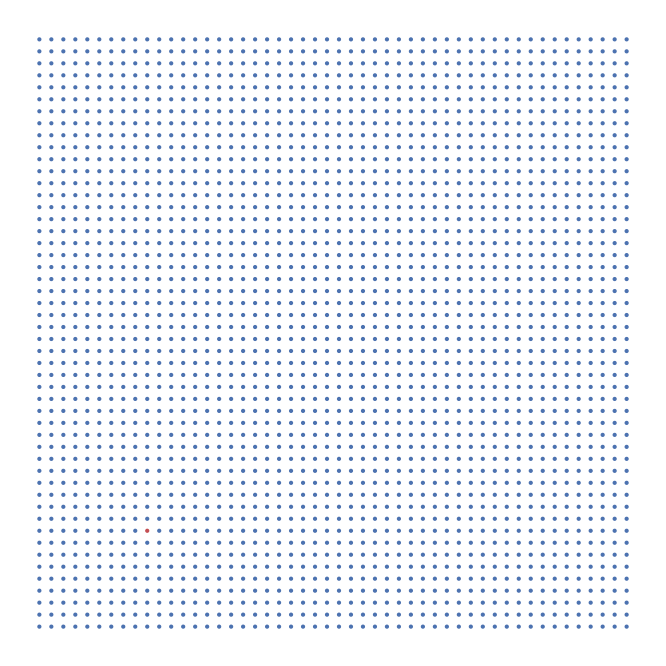

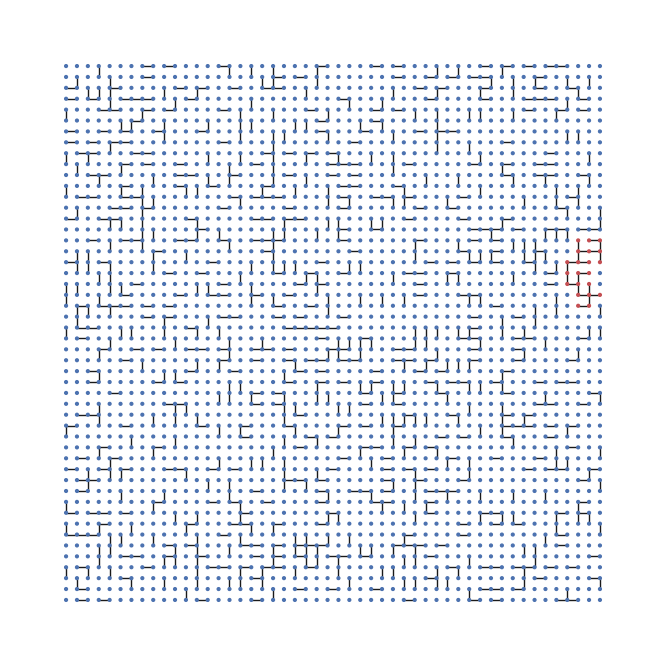

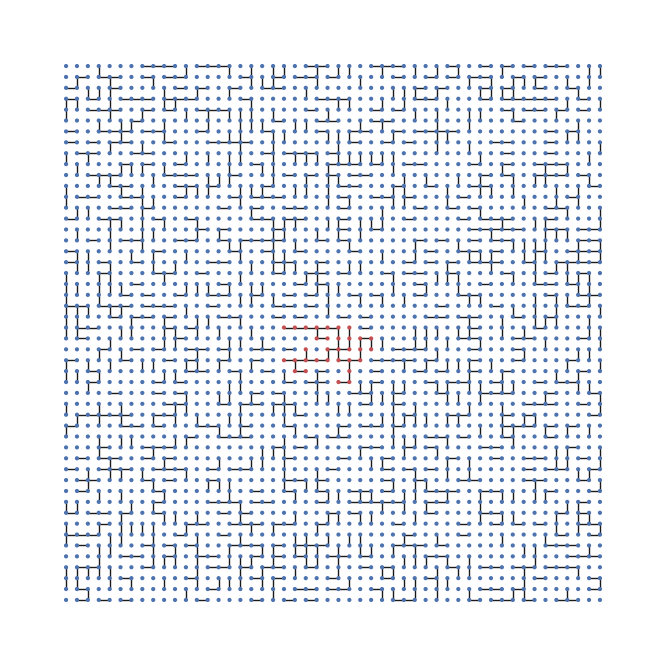

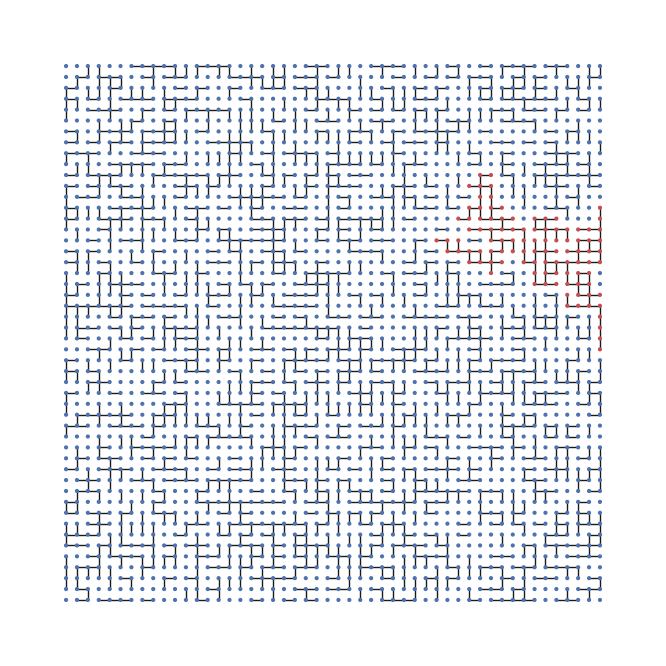

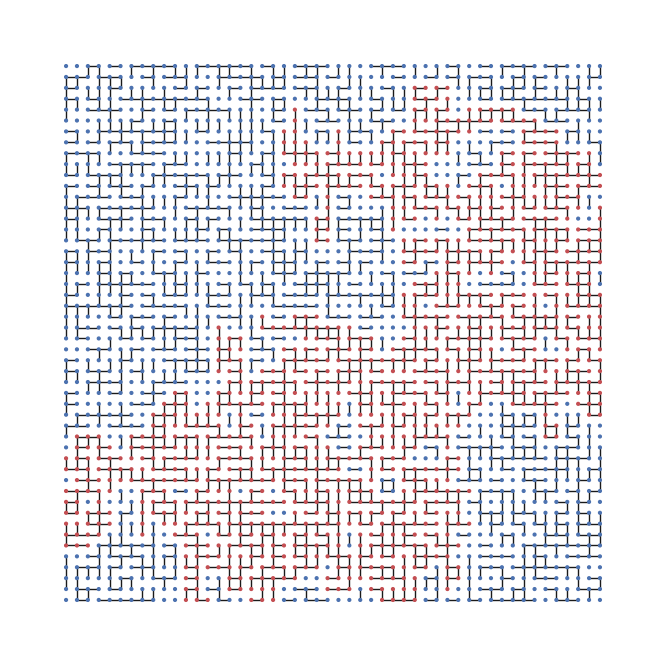

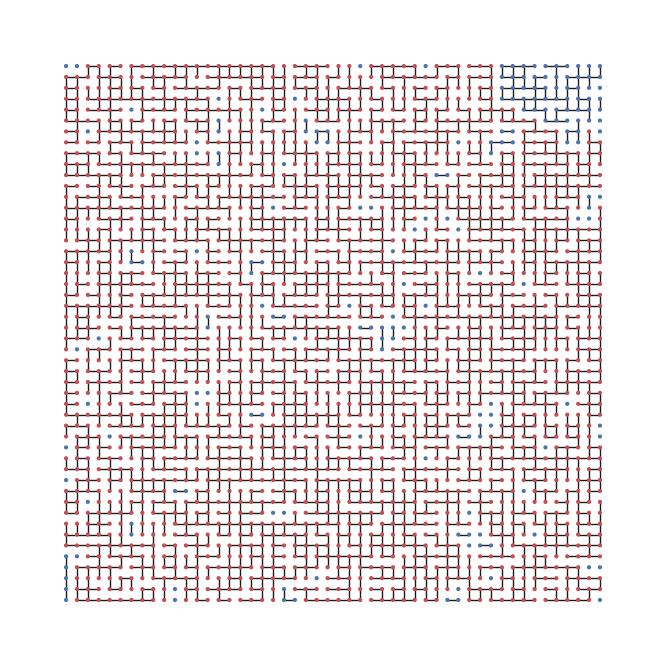

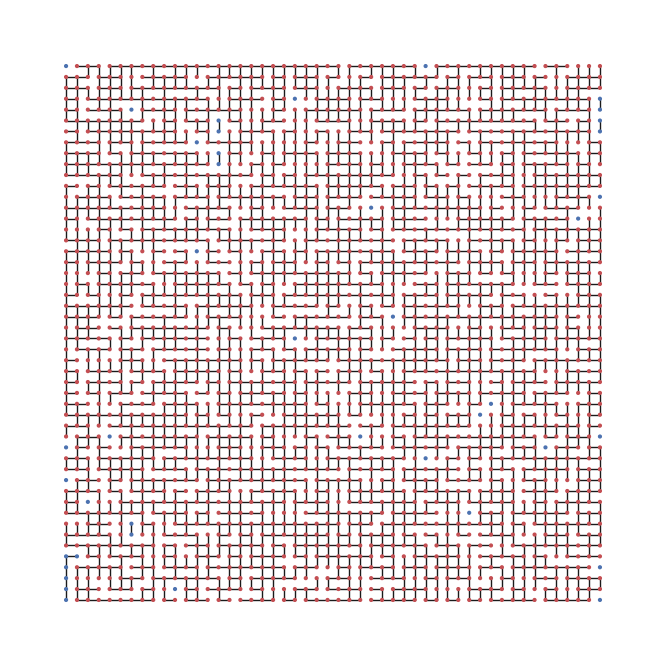

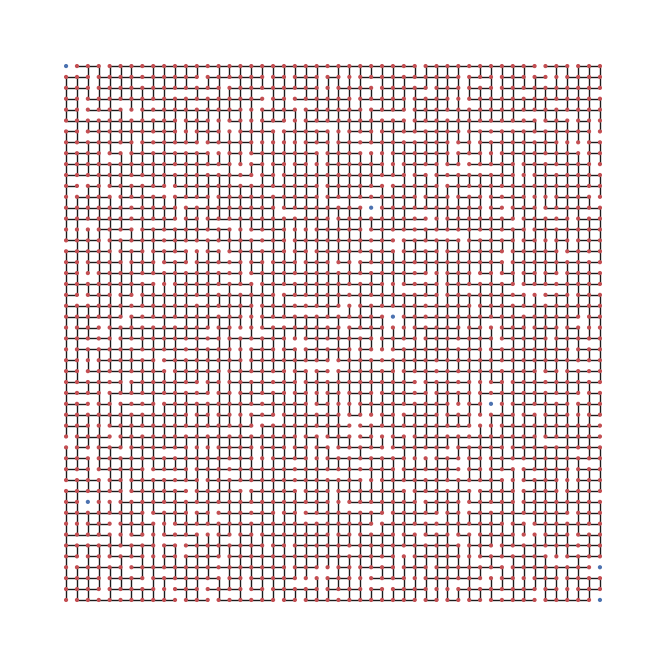

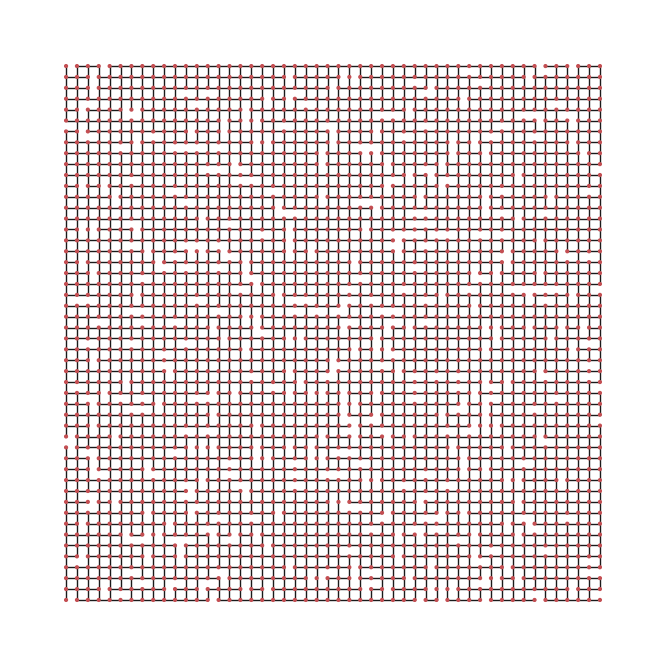

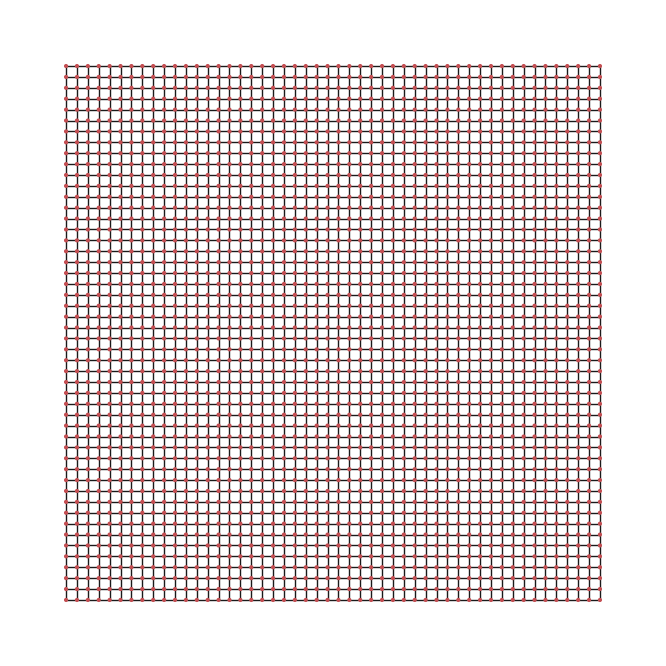

In [5]:
from matplotlib.pyplot import tight_layout


pos = {node: (node % SIDE_LENGTH, node // SIDE_LENGTH) for node in graph.nodes}
for i in range(numBonds + 1):
    if i % (numBonds // 10) == 0:
        fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
        adjacencyMatrix = bp.AdjacencyMatrix
        temp: nx.Graph = nx.from_numpy_array(np.where(adjacencyMatrix > 0, adjacencyMatrix, 0), create_using=nx.Graph)
        indicesBelongingToMaximumCluster = bp.GetIndicesBelongingToMaximumCluster()
        nodeColor = [
            'r' if node in indicesBelongingToMaximumCluster else 'b'
            for node in temp.nodes
        ]
        nx.draw(
            G=temp,
            pos=pos,
            node_size=4,
            node_color=nodeColor,
            ax=ax
        )
        ax.set_axis_off()
        #ax.margins(0.0)
        filename = f'bond_percolation-' \
            f'len{SIDE_LENGTH}-' \
            f'occ_prob{str(bp.NumOccupiedBonds / numBonds).replace(".", "")}'
        plt.savefig(
            fname='data/' + filename + '.pdf',
            format='pdf',
            dpi=80,
            bbox_inches='tight',
            metadata={
                'Creator': 'Yoshinori Kamijima',
                'Title': 'A sample of bond percolation'
            }
        )
    bp.Update()

## Computing physical quantities

In [6]:
def runSimulation(bondPercolation: simulator.BondPercolation, calculator: Callable[[simulator.BondPercolation], tuple[float, float]], oneTrialData: npt.NDArray[np.float_]) -> npt.NDArray[np.float_]:
    result = np.empty_like(oneTrialData, dtype=np.float_).reshape((oneTrialData.size // 2, 2))
    for i in range(oneTrialData.size // 2):
        result[i, 0], result[i, 1] = calculator(bondPercolation)
        bondPercolation.Update()
    return result.T.ravel()

# nptyping.NDArray[nptyping.Shape['*, Size'], nptyping.Float]  # An error occurs.
def runSimulationWrapper(graph: nx.Graph, calculator: Callable[[simulator.BondPercolation], tuple[float, float]], data: npt.NDArray[np.float_]) -> npt.NDArray[np.float_]:
    result = np.empty_like(data, dtype=np.float_)
    result = np.apply_along_axis(lambda d: runSimulation(utils.MakeFromNetworkxGraph(graph), calculator, d), 0, result)
    return result

data = np.empty(((numBonds + 1) * 2, NUM_SAMPLES), dtype=np.float_)
occupationProbabilities = np.arange(numBonds + 1) / numBonds

In [7]:
%%time

NUM_PROCESSES: int = min((os.cpu_count(), NUM_SAMPLES))
dataArray = np.array_split(data, NUM_PROCESSES, axis=1)
dataArray = joblib.Parallel(n_jobs=-1, verbose=5)([joblib.delayed(runSimulationWrapper)(graph, calcPercolationProbabilityAndMeanClusterSize, data) for data in dataArray])
data = np.concatenate(dataArray, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  1.4min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.4min remaining:   16.9s


CPU times: total: 281 ms
Wall time: 1min 38s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min finished


In [8]:
dfPercolationProbability = pd.DataFrame(data[:numBonds + 1, :], index=occupationProbabilities)
dfPercolationProbability.to_pickle(
    path=f'data/percolation_probability-len{SIDE_LENGTH}-{datetime.date.today().strftime("%Y%m%d")}.pkl.xz',
    compression='xz'
)
dfMeanClusterSize = pd.DataFrame(data[numBonds + 1:, :], index=occupationProbabilities)
dfMeanClusterSize.to_pickle(
    path=f'data/mean_cluster_size-len{SIDE_LENGTH}-{datetime.date.today().strftime("%Y%m%d")}.pkl.xz',
    compression='xz'
)
display(dfPercolationProbability, dfMeanClusterSize)

0    1    2    3    4    5    6    7    8    9   ...   15   16  \
0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
0.000204  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
0.000408  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
0.000612  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
0.000816  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0.999184  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
0.999388  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
0.999592  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
0.999796  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

           17   18   19   20   21   22   23   24  
0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.000204  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.000408  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.000612  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
0.000816  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...       ...  ...  ...  ...  ...  ...  ...  ...  
0.999184  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0.999388  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0.999592  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
0.999796  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[4901 rows x 25 columns]

0       1       2       3       4       5       6       7   \
0.000000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.000204  1.0008  1.0008  1.0008  1.0008  1.0008  1.0008  1.0008  1.0008   
0.000408  1.0016  1.0016  1.0016  1.0016  1.0016  1.0016  1.0016  1.0016   
0.000612  1.0024  1.0024  1.0024  1.0024  1.0024  1.0024  1.0024  1.0024   
0.000816  1.0032  1.0032  1.0032  1.0032  1.0032  1.0032  1.0032  1.0032   
...          ...     ...     ...     ...     ...     ...     ...     ...   
0.999184  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.999388  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.999592  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.999796  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
1.000000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   

              8       9   ...      15      16      17      18      19      20  \
0.000000  1.0000  1.0000  ...  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.000204  1.0008  1.0008  ...  1.0008  1.0008  1.0008  1.0008  1.0008  1.0008   
0.000408  1.0016  1.0016  ...  1.0016  1.0016  1.0016  1.0016  1.0016  1.0016   
0.000612  1.0024  1.0024  ...  1.0024  1.0024  1.0024  1.0024  1.0024  1.0024   
0.000816  1.0032  1.0032  ...  1.0032  1.0032  1.0032  1.0032  1.0032  1.0032   
...          ...     ...  ...     ...     ...     ...     ...     ...     ...   
0.999184  1.0000  1.0000  ...  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.999388  1.0000  1.0000  ...  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.999592  1.0000  1.0000  ...  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
0.999796  1.0000  1.0000  ...  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
1.000000  1.0000  1.0000  ...  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   

              21      22      23      24  
0.000000  1.0000  1.0000  1.0000  1.0000  
0.000204  1.0008  1.0008  1.0008  1.0008  
0.000408  1.0016  1.0016  1.0016  1.0016  
0.000612  1.0024  1.0024  1.0024  1.0024  
0.000816  1.0032  1.0032  1.0032  1.0032  
...          ...     ...     ...     ...  
0.999184  1.0000  1.0000  1.0000  1.0000  
0.999388  1.0000  1.0000  1.0000  1.0000  
0.999592  1.0000  1.0000  1.0000  1.0000  
0.999796  1.0000  1.0000  1.0000  1.0000  
1.000000  1.0000  1.0000  1.0000  1.0000  

[4901 rows x 25 columns]

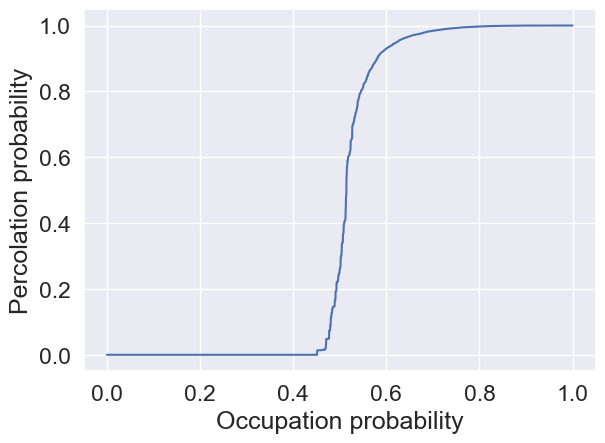

In [9]:
fig, ax = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)
sns.lineplot(data=dfPercolationProbability.mean(axis=1), ax=ax)
ax.set(xlabel='Occupation probability', ylabel='Percolation probability')
filename = f'percolation_probability-len{SIDE_LENGTH}'
plt.savefig(
    fname='data/' + filename + '.pdf',
    format='pdf',
    dpi=80,
    bbox_inches='tight',
    metadata={
        'Creator': 'Yoshinori Kamijima',
        'Title': 'Percolation probability for bond percolation'
    }
)

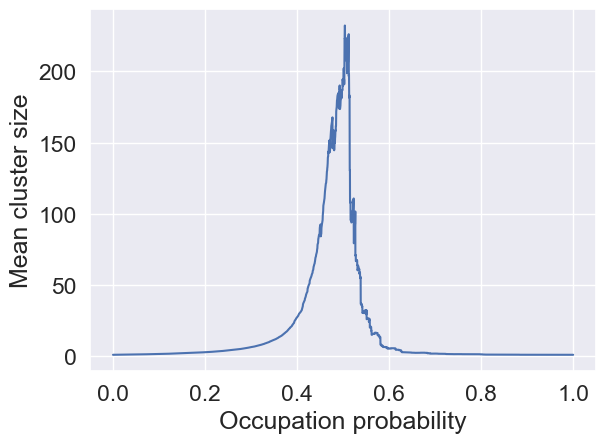

In [10]:
fig, ax = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)
sns.lineplot(data=dfMeanClusterSize.mean(axis=1), ax=ax)
ax.set(xlabel='Occupation probability', ylabel='Mean cluster size')
filename = f'mean_cluster_size-len{SIDE_LENGTH}'
plt.savefig(
    fname='data/' + filename + '.pdf',
    format='pdf',
    dpi=80,
    bbox_inches='tight',
    metadata={
        'Creator': 'Yoshinori Kamijima',
        'Title': 'Mean cluster size for bond percolation'
    }
)